## In The Name Of God
### Deep Learning Homework No.2
----------------

#### Ali Khoramfar
#### 810102129

#### MohammadMahdi Barghi
#### 810102092

----------------

#### Ordibehesht 1403

# Q1

In [ ]:
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as tt
import torchvision.models as models


from torch import optim
from torch.nn.init import xavier_uniform_
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader,WeightedRandomSampler

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

path = '/content/gdrive/My Drive/Colab Notebooks/NNDL HW2/'

import zipfile
with zipfile.ZipFile(path+'Q1Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(path)


In [ ]:
if torch.cuda.is_available():
    device= torch.device('cuda')
else:
    device= torch.device('cpu')

## 1-2 Normalize Photos

In [ ]:
classes = ['MCI', 'AD']
data_dir = '/content/gdrive/My Drive/Colab Notebooks/NNDL HW2/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

In [ ]:
X = []
y = []


for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)

    for filename in tqdm(os.listdir(class_dir), desc=f'Preprocessing {class_name}'):
        file_path = os.path.join(class_dir, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            X.append(img)
            y.append(class_index)

X = np.array(X, dtype=np.float32) / 255.0  # Normalize
y = np.array(y, dtype=np.int64)

# Print the shape of the arrays
print('X shape:', X.shape)
print('y shape:', y.shape)

Preprocessing AD: 100%|██████████| 965/965 [00:09<00:00, 98.00it/s] 

X shape: (1654, 64, 64)
y shape: (1654,)


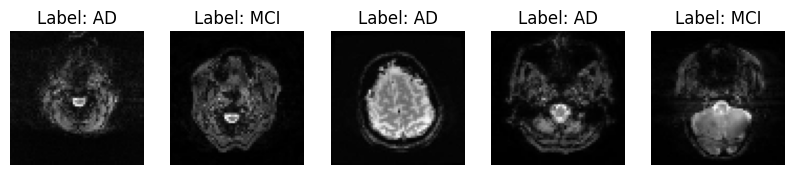

In [ ]:
def display_images(images, labels, indices):
    plt.figure(figsize=(10, 2))
    for i, index in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title('Label: ' + ('MCI' if labels[index] == 0 else 'AD'))
        plt.axis('off')
    plt.show()

random_photos = np.random.choice(len(X), 5, replace=False)

# Display the images and labels
display_images(X, y, random_photos)


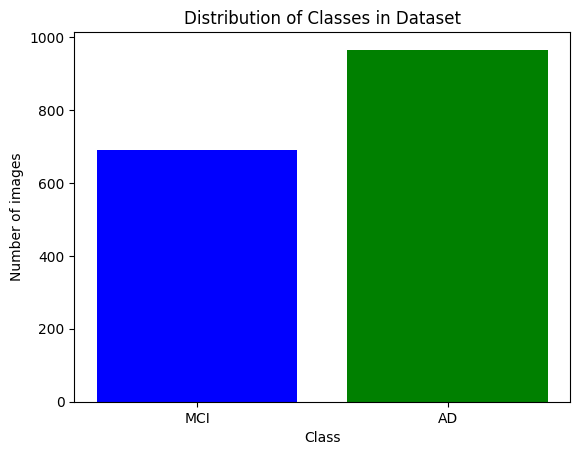

In [ ]:
class_counts = np.bincount(y)

# Plotting the class distribution
plt.bar(classes, class_counts, color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of Classes in Dataset')
plt.show()


## 1-3 Data augmentation

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2
)

In [ ]:
base_save_dir = '/content/gdrive/My Drive/Colab Notebooks/NNDL HW2/Augmented_Data'
os.makedirs(base_save_dir, exist_ok=True)

X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

for i, (img, label) in enumerate(zip(X, y)):
    class_dir = os.path.join(base_save_dir, str(classes[label]))
    os.makedirs(class_dir, exist_ok=True)

    # Save the original image
    original_img_path = os.path.join(class_dir, f"original_{i}.png")
    cv2.imwrite(original_img_path, img.squeeze() * 255)

    img = np.expand_dims(img, axis=0)

    # Generate and save 4 new images
    for x, val in enumerate(data_gen.flow(img, batch_size=1)):
        augmented_img_path = os.path.join(class_dir, f"augmented_{i}_{x}.png")
        cv2.imwrite(augmented_img_path, val[0].squeeze() * 255)
        if x >= 3:
            break

In [ ]:
# Load image paths and labels
image_paths = []
labels = []

for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(base_save_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith(".png"):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(class_index)

image_paths = np.array(image_paths)
labels = np.array(labels)

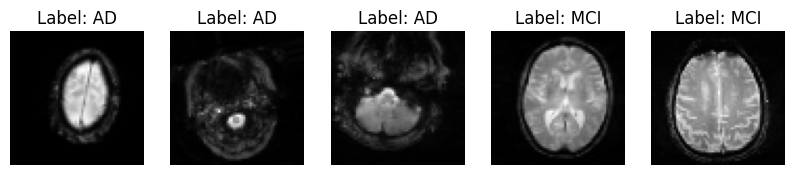

In [ ]:
def display_images(image_paths, labels, indices):
    plt.figure(figsize=(10, 2))
    for i, index in enumerate(indices):
        img = Image.open(image_paths[index]).convert('L')
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title('Label: ' + ('MCI' if labels[index] == 0 else 'AD'))
        plt.axis('off')
    plt.show()

random_indices = np.random.choice(len(image_paths), 5, replace=False)
display_images(image_paths, labels, random_indices)

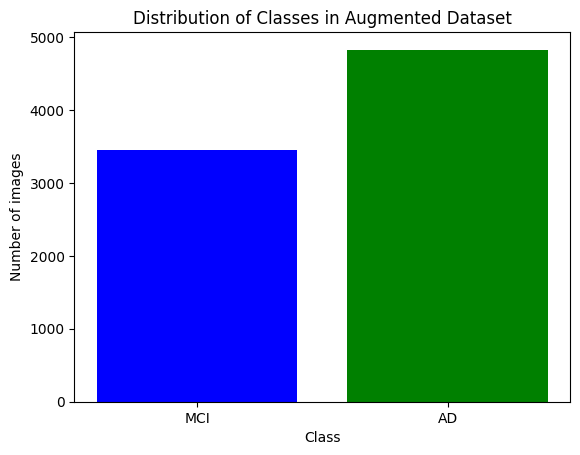

In [ ]:
class_counts = np.bincount(labels)
plt.bar(classes, class_counts, color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of Classes in Augmented Dataset')
plt.show()

##Implementation

##Dataset with Augmentation

In [ ]:
data2_dir = '/content/gdrive/My Drive/Colab Notebooks/NNDL HW2/Augmented_Data'
dataset = ImageFolder(
                        data2_dir,
                        transform=tt.Compose([
                                              #tt.Normalize(mean=[], std=[0, 0, 0] ,inplace=True),
                                              tt.Resize((64, 64)),
                                              tt.Grayscale(num_output_channels=1),
                                              tt.ToTensor(),
                                              tt.Normalize(mean=[0.5], std=[0.5])
                                           ])
                      )
torch.manual_seed(42)
total_size = len(dataset)


test_size = int(0.05 * total_size)  # 5% for testing
train_size = total_size - test_size  # 95% for training

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_train_size = int(0.9 * train_size)  # 90% of training set
val_size = train_size - train_train_size  # Remaining for validation

train_dataset, val_dataset = random_split(train_dataset, [train_train_size, val_size])



# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 8270
    Root location: /content/gdrive/My Drive/Colab Notebooks/NNDL HW2/Augmented_Data
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

##Models

In [ ]:
class ProposedModel(nn.Module):
    def __init__(self):
        super(ProposedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ProposedModel_Dropout(nn.Module):
    def __init__(self):
        super(ProposedModel_Dropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        # Dropout layers
        self.dropout1 = nn.Dropout2d(p=0.2)  # after first convolutional layer
        self.dropout3 = nn.Dropout2d(p=0.2)  # after third convolutional layer

        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc = nn.Dropout(p=0.2)  # after first fully connected layer
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)  # after the first convolutional layer

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout3(x)  # after third convolutional layer

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 32 * 16 * 16)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # after first fully connected layer

        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

class TestingModel1(nn.Module):
    def __init__(self):
        super(TestingModel1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TestingModel2(nn.Module):
    def __init__(self):
        super(TestingModel2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        batch_size = x.size(0)
        flattened_size = 32 * 32 * 32
        x = x.view(batch_size, flattened_size)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / train_total

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')

        model.train()

    return train_losses, val_losses, train_accuracies, val_accuracies


## Visualize Result

In [ ]:
def visualize_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epoch")

    plt.tight_layout()
    plt.show()



def evaluate_model(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    report = classification_report(test_labels, test_preds)
    print("Classification Report:")
    print(report)

    precision = precision_score(test_labels, test_preds, average="macro")
    recall = recall_score(test_labels, test_preds, average="macro")
    f1 = f1_score(test_labels, test_preds, average="macro")
    auc_score = roc_auc_score(test_labels, test_preds, multi_class="ovo")

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 or DSC Score: {f1:.4f}, AUC: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, test_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.show()




##Result After Augmentation

In [ ]:
model = ProposedModel()
model.to(device)
num_epochs = 20
# Glorot initialization
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1], train_loss: 0.6703, train_acc: 0.5869, val_loss: 0.6633, val_acc: 0.6014
Epoch [2], train_loss: 0.6287, train_acc: 0.6382, val_loss: 0.6426, val_acc: 0.5894
Epoch [3], train_loss: 0.6100, train_acc: 0.6586, val_loss: 0.6251, val_acc: 0.6498
Epoch [4], train_loss: 0.5530, train_acc: 0.7154, val_loss: 0.6263, val_acc: 0.6763
Epoch [5], train_loss: 0.4997, train_acc: 0.7525, val_loss: 0.5757, val_acc: 0.6981
Epoch [6], train_loss: 0.4135, train_acc: 0.8060, val_loss: 0.5155, val_acc: 0.7367
Epoch [7], train_loss: 0.3467, train_acc: 0.8424, val_loss: 0.4890, val_acc: 0.7826
Epoch [8], train_loss: 0.2593, train_acc: 0.8897, val_loss: 0.4790, val_acc: 0.7971
Epoch [9], train_loss: 0.1735, train_acc: 0.9312, val_loss: 0.4847, val_acc: 0.8430
Epoch [10], train_loss: 0.1265, train_acc: 0.9496, val_loss: 0.5175, val_acc: 0.8116
Epoch [11], train_loss: 0.0790, train_acc: 0.9733, val_loss: 0.7124, val_acc: 0.7802
Epoch [12], train_loss: 0.0687, train_acc: 0.9768, val_loss: 0.5799, val_a

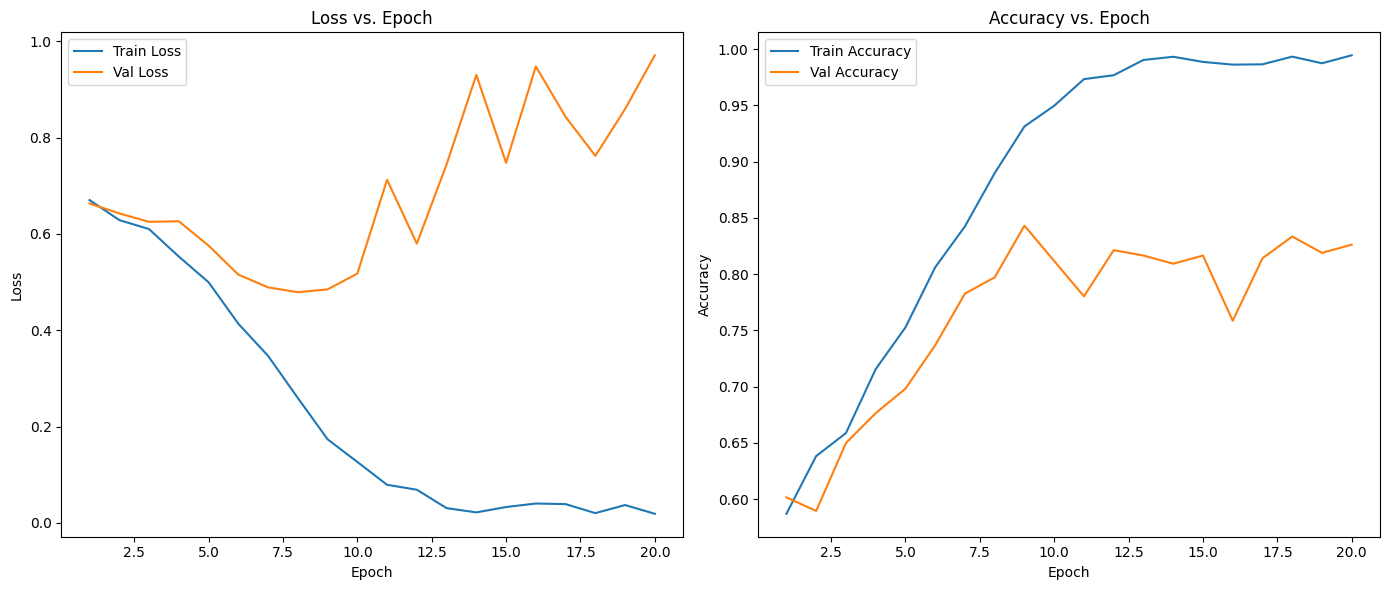

Confusion Matrix:
[[203  33]
 [ 41 136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       236
           1       0.80      0.77      0.79       177

    accuracy                           0.82       413
   macro avg       0.82      0.81      0.82       413
weighted avg       0.82      0.82      0.82       413

Precision: 0.8184, Recall: 0.8143, F1 or DSC Score: 0.8160, AUC: 0.8143


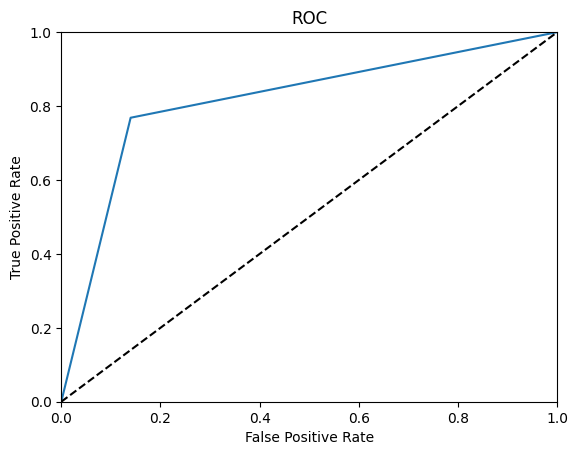

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

## Train with 0.3 Split

In [ ]:
test_size = int(0.3 * total_size)  # 30% for testing
train_size = total_size - test_size  # 70% for training

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_train_size = int(0.9 * train_size)  # 90% of training set
val_size = train_size - train_train_size  # Remaining for validation

train_dataset, val_dataset = random_split(train_dataset, [train_train_size, val_size])

# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


model = ProposedModel()
model.to(device)
num_epochs = 20
# Glorot initialization
model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], train_loss: 0.6708, train_acc: 0.5948, val_loss: 0.6595, val_acc: 0.6149
Epoch [2], train_loss: 0.6254, train_acc: 0.6449, val_loss: 0.6287, val_acc: 0.6408
Epoch [3], train_loss: 0.5987, train_acc: 0.6699, val_loss: 0.6375, val_acc: 0.6494
Epoch [4], train_loss: 0.5700, train_acc: 0.7031, val_loss: 0.5703, val_acc: 0.6995
Epoch [5], train_loss: 0.5186, train_acc: 0.7415, val_loss: 0.5669, val_acc: 0.7133
Epoch [6], train_loss: 0.4687, train_acc: 0.7653, val_loss: 0.5712, val_acc: 0.7116
Epoch [7], train_loss: 0.4011, train_acc: 0.8163, val_loss: 0.5342, val_acc: 0.7306
Epoch [8], train_loss: 0.3376, train_acc: 0.8497, val_loss: 0.5119, val_acc: 0.7582
Epoch [9], train_loss: 0.2383, train_acc: 0.8992, val_loss: 0.5518, val_acc: 0.7772
Epoch [10], train_loss: 0.1529, train_acc: 0.9401, val_loss: 0.6601, val_acc: 0.7807
Epoch [11], train_loss: 0.1044, train_acc: 0.9585, val_loss: 0.7830, val_acc: 0.7686
Epoch [12], train_loss: 0.0588, train_acc: 0.9779, val_loss: 0.9311, val_a

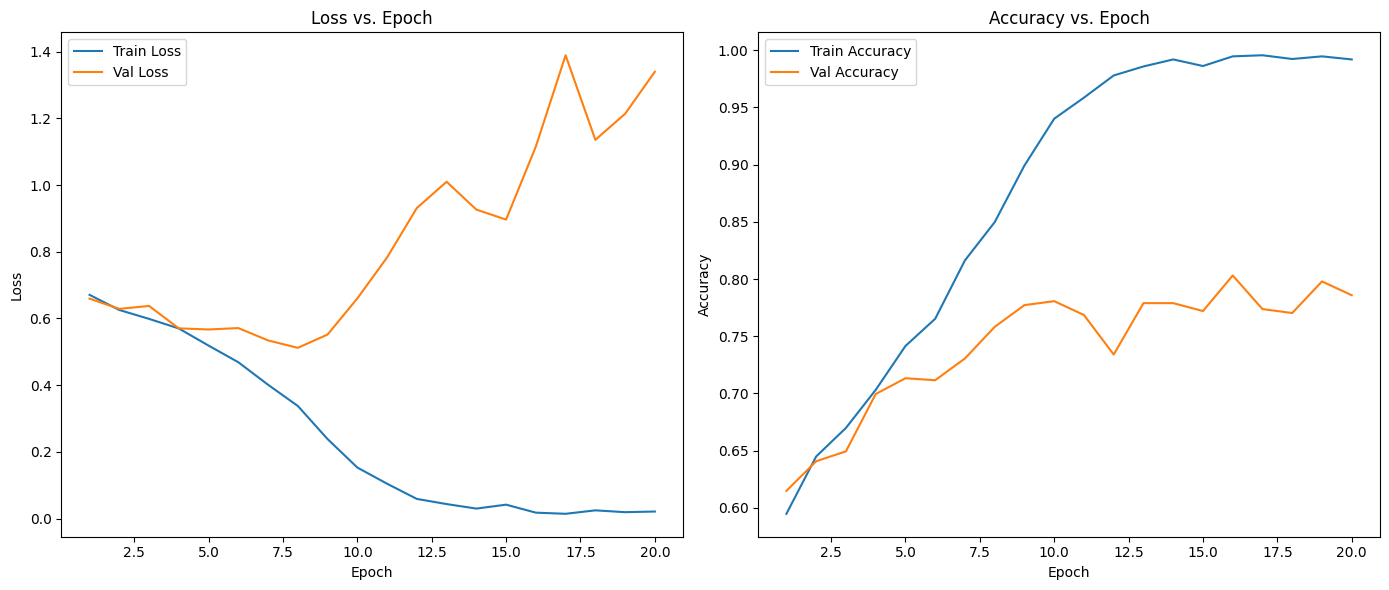

Confusion Matrix:
[[1204  202]
 [ 338  737]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1406
           1       0.78      0.69      0.73      1075

    accuracy                           0.78      2481
   macro avg       0.78      0.77      0.77      2481
weighted avg       0.78      0.78      0.78      2481

Precision: 0.7828, Recall: 0.7710, F1 or DSC Score: 0.7744, AUC: 0.7710


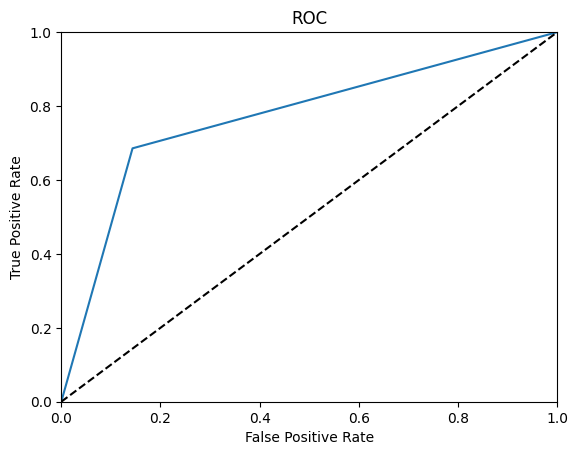

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

## Train with 0.5 Split

In [ ]:
test_size = int(0.5 * total_size)  # 50% for testing
train_size = total_size - test_size  # 50% for training

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_train_size = int(0.9 * train_size)  # 90% of training set
val_size = train_size - train_train_size  # Remaining for validation

train_dataset, val_dataset = random_split(train_dataset, [train_train_size, val_size])

# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


model = ProposedModel()
model.to(device)
num_epochs = 20
# Glorot initialization
model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], train_loss: 0.6670, train_acc: 0.6010, val_loss: 0.6987, val_acc: 0.5780
Epoch [2], train_loss: 0.6347, train_acc: 0.6433, val_loss: 0.6347, val_acc: 0.6493
Epoch [3], train_loss: 0.6155, train_acc: 0.6636, val_loss: 0.6210, val_acc: 0.6578
Epoch [4], train_loss: 0.5774, train_acc: 0.6895, val_loss: 0.6329, val_acc: 0.6602
Epoch [5], train_loss: 0.5423, train_acc: 0.7125, val_loss: 0.5867, val_acc: 0.7050
Epoch [6], train_loss: 0.4913, train_acc: 0.7553, val_loss: 0.6284, val_acc: 0.6747
Epoch [7], train_loss: 0.4482, train_acc: 0.7828, val_loss: 0.5790, val_acc: 0.7183
Epoch [8], train_loss: 0.3485, train_acc: 0.8426, val_loss: 0.5440, val_acc: 0.7424
Epoch [9], train_loss: 0.2581, train_acc: 0.8941, val_loss: 0.5946, val_acc: 0.7703
Epoch [10], train_loss: 0.1712, train_acc: 0.9328, val_loss: 0.7186, val_acc: 0.7424
Epoch [11], train_loss: 0.1116, train_acc: 0.9570, val_loss: 0.7706, val_acc: 0.7751
Epoch [12], train_loss: 0.0715, train_acc: 0.9724, val_loss: 0.9233, val_a

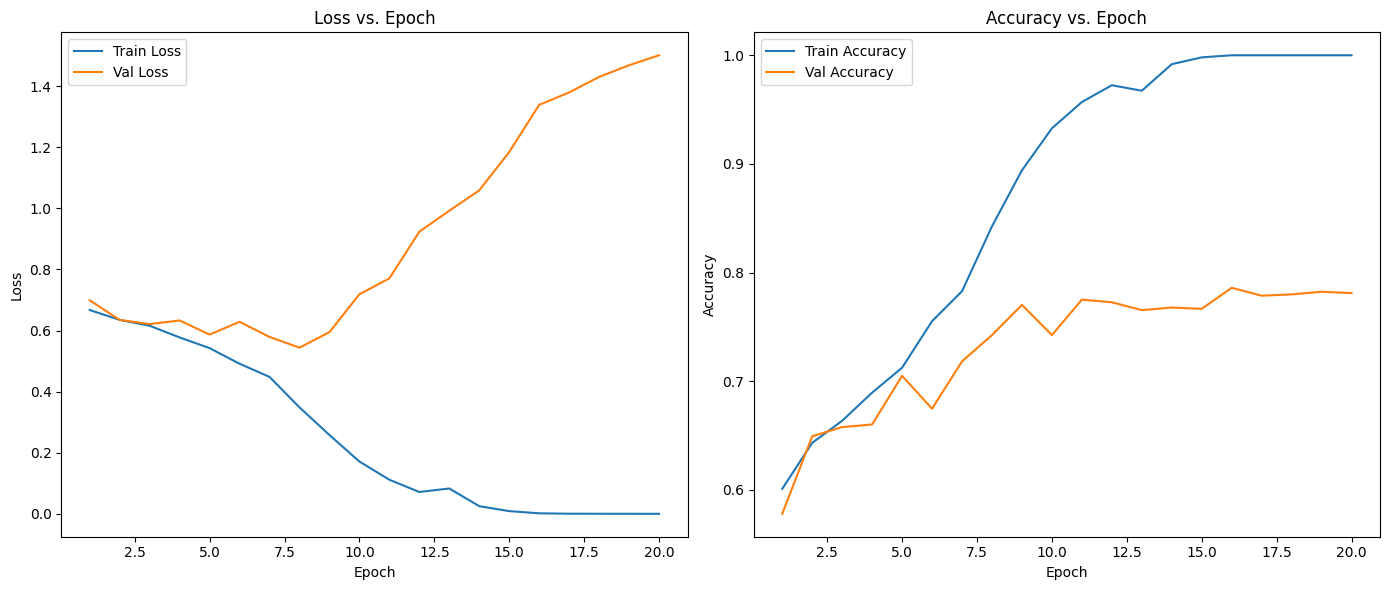

Confusion Matrix:
[[1613  320]
 [ 417  958]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1933
           1       0.75      0.70      0.72      1375

    accuracy                           0.78      3308
   macro avg       0.77      0.77      0.77      3308
weighted avg       0.78      0.78      0.78      3308

Precision: 0.7721, Recall: 0.7656, F1 or DSC Score: 0.7681, AUC: 0.7656


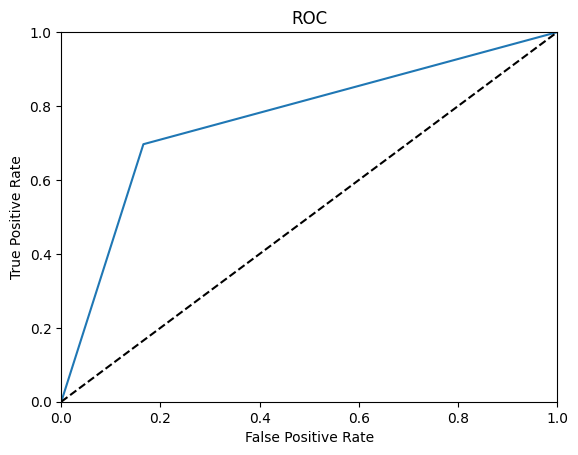

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

## Dropout Effect

In [ ]:
test_size = int(0.05 * total_size)  # 5% for testing
train_size = total_size - test_size  # 95% for training

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_train_size = int(0.9 * train_size)  # 90% of training set
val_size = train_size - train_train_size  # Remaining for validation

train_dataset, val_dataset = random_split(train_dataset, [train_train_size, val_size])

# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


model = ProposedModel_Dropout()
model.to(device)
num_epochs = 20
# Glorot initialization
model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], train_loss: 0.6726, train_acc: 0.5893, val_loss: 0.6649, val_acc: 0.5990
Epoch [2], train_loss: 0.6550, train_acc: 0.6100, val_loss: 0.6567, val_acc: 0.6353
Epoch [3], train_loss: 0.6432, train_acc: 0.6241, val_loss: 0.6501, val_acc: 0.6111
Epoch [4], train_loss: 0.6248, train_acc: 0.6586, val_loss: 0.6252, val_acc: 0.6643
Epoch [5], train_loss: 0.6034, train_acc: 0.6848, val_loss: 0.6162, val_acc: 0.6715
Epoch [6], train_loss: 0.5896, train_acc: 0.6996, val_loss: 0.6389, val_acc: 0.6401
Epoch [7], train_loss: 0.5710, train_acc: 0.7256, val_loss: 0.5924, val_acc: 0.6860
Epoch [8], train_loss: 0.5451, train_acc: 0.7545, val_loss: 0.5877, val_acc: 0.7174
Epoch [9], train_loss: 0.5289, train_acc: 0.7724, val_loss: 0.5671, val_acc: 0.7464
Epoch [10], train_loss: 0.5130, train_acc: 0.7918, val_loss: 0.5908, val_acc: 0.7053
Epoch [11], train_loss: 0.5061, train_acc: 0.7999, val_loss: 0.5752, val_acc: 0.7367
Epoch [12], train_loss: 0.4804, train_acc: 0.8284, val_loss: 0.5736, val_a

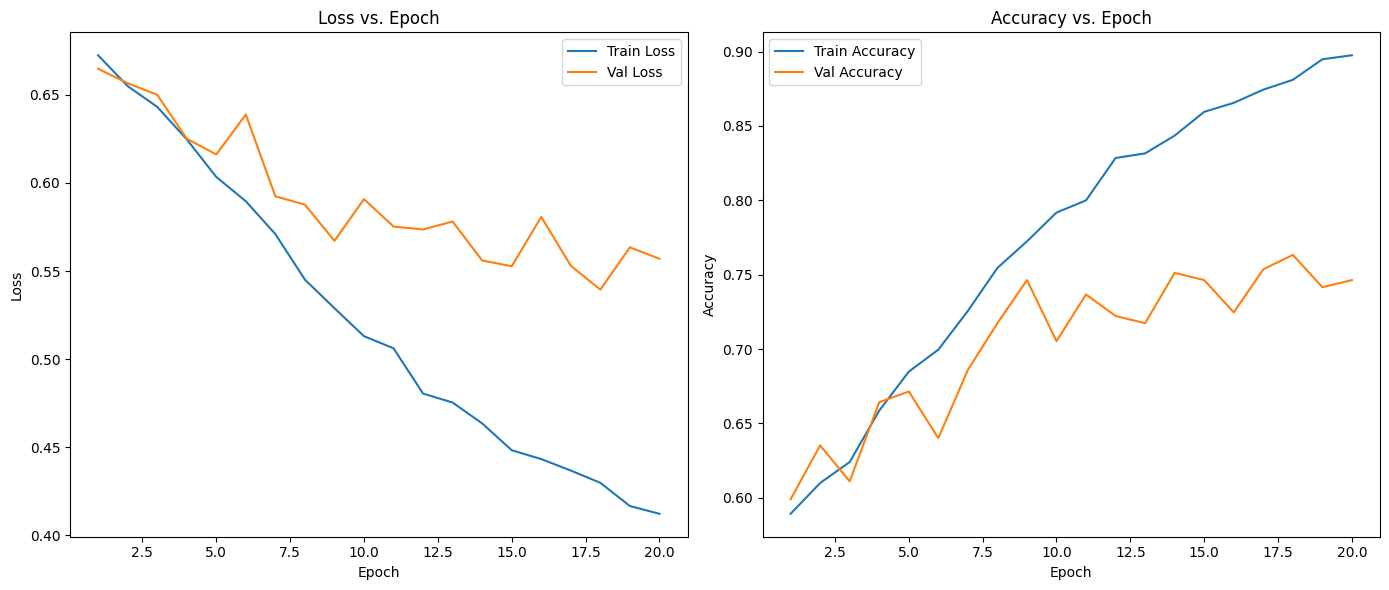

Confusion Matrix:
[[209  33]
 [ 50 121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       242
           1       0.79      0.71      0.74       171

    accuracy                           0.80       413
   macro avg       0.80      0.79      0.79       413
weighted avg       0.80      0.80      0.80       413

Precision: 0.7963, Recall: 0.7856, F1 or DSC Score: 0.7895, AUC: 0.7856


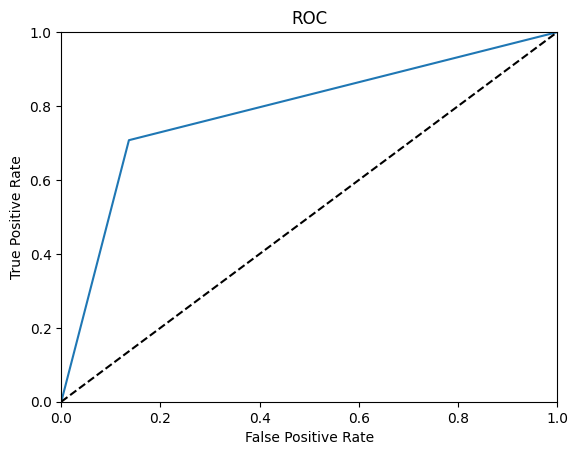

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

##Glorot Initializer Effect

In [ ]:
def init_weights_ones(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def init_weights_zeros(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.fill_(0)
        if m.bias is not None:
            m.bias.data.fill_(0.01)


### Ones Initializer

In [ ]:
model = ProposedModel()
model.to(device)
num_epochs = 5

model.apply(init_weights_ones)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1], train_loss: 92169110566.1153, train_acc: 0.5111, val_loss: 126651559639.1884, val_acc: 0.5749
Epoch [2], train_loss: 39820808575.5701, train_acc: 0.5228, val_loss: 18665260022.1063, val_acc: 0.5749
Epoch [3], train_loss: 12919329810.2980, train_acc: 0.5100, val_loss: 43000562455.4976, val_acc: 0.4275
Epoch [4], train_loss: 14371175740.1564, train_acc: 0.5181, val_loss: 15290205129.5845, val_acc: 0.4275
Epoch [5], train_loss: 8737699293.3301, train_acc: 0.5091, val_loss: 11256473362.5507, val_acc: 0.5773


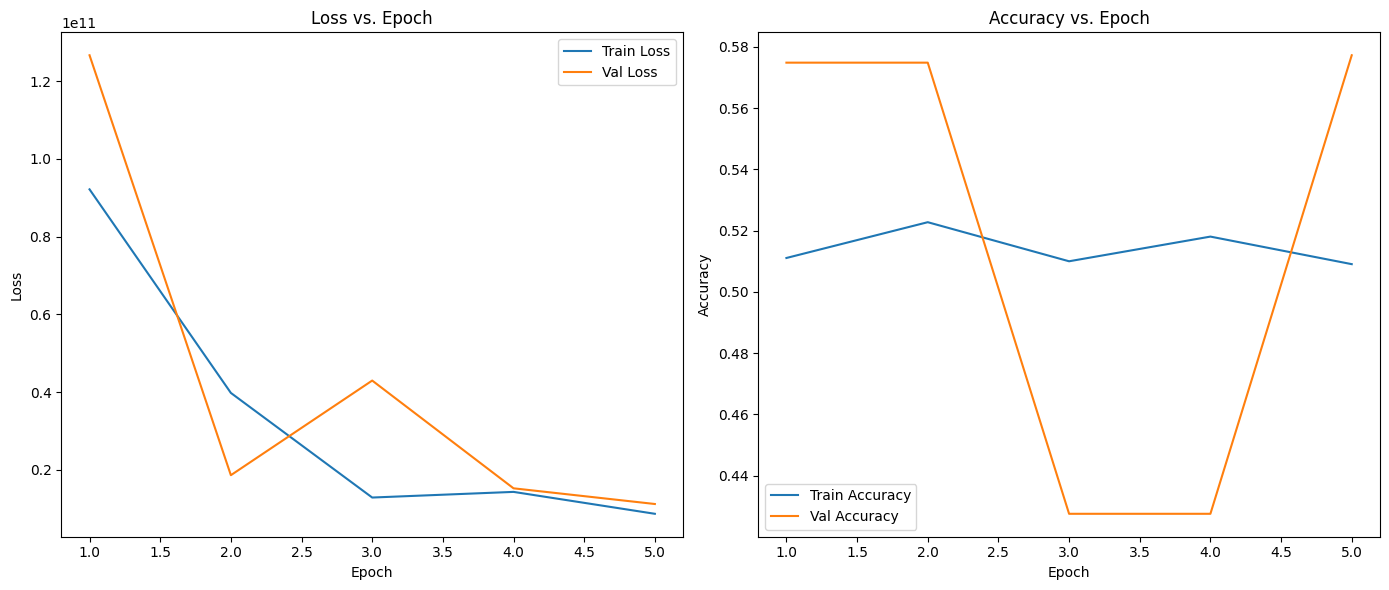

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)

### Zeros Initializer

In [ ]:
model = ProposedModel()
model.to(device)
num_epochs = 5

model.apply(init_weights_zeros)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], train_loss: 0.6826, train_acc: 0.5839, val_loss: 0.6830, val_acc: 0.5725
Epoch [2], train_loss: 0.6810, train_acc: 0.5839, val_loss: 0.6827, val_acc: 0.5725
Epoch [3], train_loss: 0.6795, train_acc: 0.5839, val_loss: 0.6827, val_acc: 0.5725
Epoch [4], train_loss: 0.6793, train_acc: 0.5839, val_loss: 0.6827, val_acc: 0.5725
Epoch [5], train_loss: 0.6792, train_acc: 0.5839, val_loss: 0.6827, val_acc: 0.5725


##Testing Model 1

In [ ]:
model = TestingModel1()
model.to(device)
num_epochs = 20
# Glorot initialization
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1], train_loss: 0.6745, train_acc: 0.5863, val_loss: 0.6774, val_acc: 0.5700
Epoch [2], train_loss: 0.6352, train_acc: 0.6327, val_loss: 0.6359, val_acc: 0.6522
Epoch [3], train_loss: 0.5859, train_acc: 0.6857, val_loss: 0.6202, val_acc: 0.6715
Epoch [4], train_loss: 0.5598, train_acc: 0.6994, val_loss: 0.6060, val_acc: 0.6787
Epoch [5], train_loss: 0.5116, train_acc: 0.7396, val_loss: 0.6311, val_acc: 0.6449
Epoch [6], train_loss: 0.4669, train_acc: 0.7728, val_loss: 0.5474, val_acc: 0.6957
Epoch [7], train_loss: 0.4267, train_acc: 0.8020, val_loss: 0.5766, val_acc: 0.6957
Epoch [8], train_loss: 0.3696, train_acc: 0.8342, val_loss: 0.5647, val_acc: 0.7053
Epoch [9], train_loss: 0.3103, train_acc: 0.8686, val_loss: 0.5163, val_acc: 0.7343
Epoch [10], train_loss: 0.2659, train_acc: 0.8867, val_loss: 0.5319, val_acc: 0.7512
Epoch [11], train_loss: 0.2357, train_acc: 0.9041, val_loss: 0.5475, val_acc: 0.7585
Epoch [12], train_loss: 0.1924, train_acc: 0.9219, val_loss: 0.5571, val_a

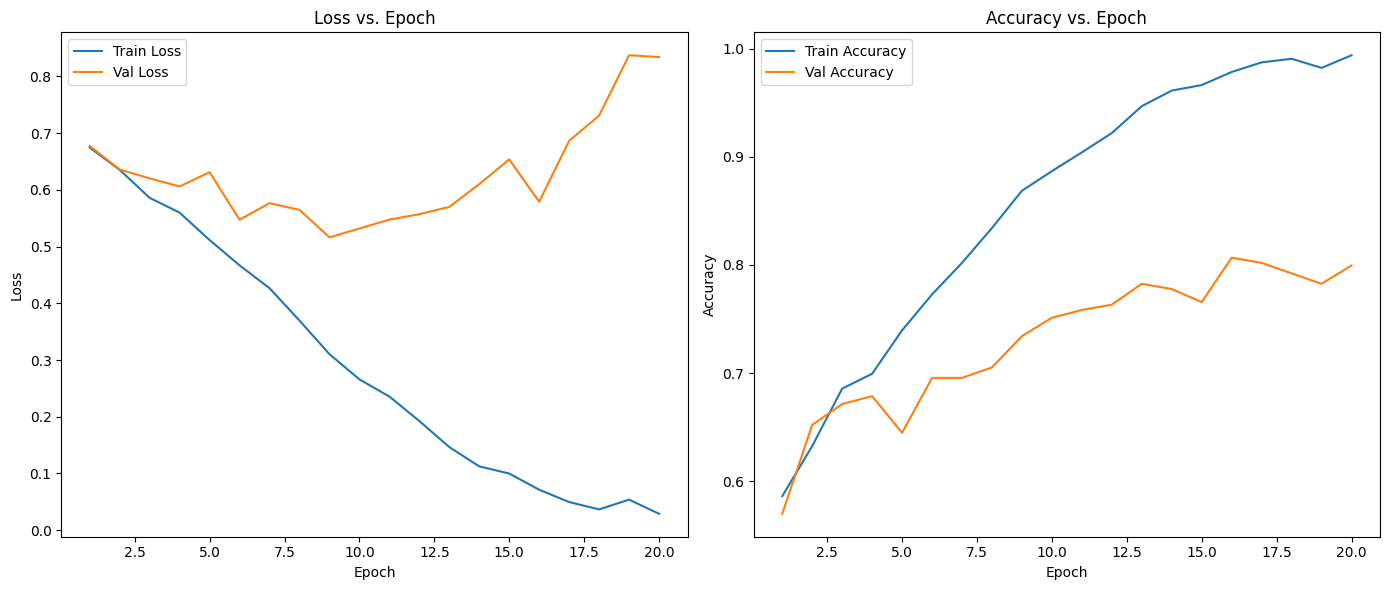

Confusion Matrix:
[[179  63]
 [ 29 142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       242
           1       0.69      0.83      0.76       171

    accuracy                           0.78       413
   macro avg       0.78      0.79      0.78       413
weighted avg       0.79      0.78      0.78       413

Precision: 0.7766, Recall: 0.7850, F1 or DSC Score: 0.7754, AUC: 0.7850


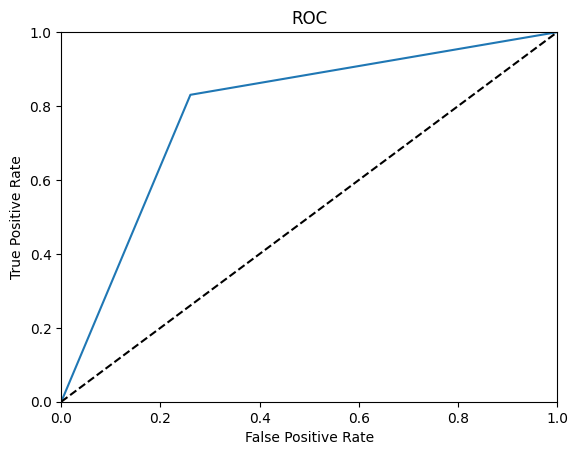

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

##Testing Model 2

In [ ]:
model = TestingModel2()
model.to(device)
num_epochs = 20
# Glorot initialization
model.apply(init_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1], train_loss: 0.6902, train_acc: 0.5957, val_loss: 0.6722, val_acc: 0.5700
Epoch [2], train_loss: 0.6160, train_acc: 0.6547, val_loss: 0.6269, val_acc: 0.6643
Epoch [3], train_loss: 0.5654, train_acc: 0.6954, val_loss: 0.5999, val_acc: 0.6715
Epoch [4], train_loss: 0.4988, train_acc: 0.7439, val_loss: 0.5930, val_acc: 0.7029
Epoch [5], train_loss: 0.3873, train_acc: 0.8232, val_loss: 0.5980, val_acc: 0.6763
Epoch [6], train_loss: 0.2703, train_acc: 0.8826, val_loss: 0.6142, val_acc: 0.7295
Epoch [7], train_loss: 0.1583, train_acc: 0.9377, val_loss: 0.6746, val_acc: 0.7488
Epoch [8], train_loss: 0.0890, train_acc: 0.9700, val_loss: 0.7997, val_acc: 0.7391
Epoch [9], train_loss: 0.0292, train_acc: 0.9931, val_loss: 0.9896, val_acc: 0.7536
Epoch [10], train_loss: 0.0137, train_acc: 0.9970, val_loss: 1.1804, val_acc: 0.7367
Epoch [11], train_loss: 0.0200, train_acc: 0.9938, val_loss: 1.3187, val_acc: 0.7319
Epoch [12], train_loss: 0.0333, train_acc: 0.9893, val_loss: 1.0828, val_a

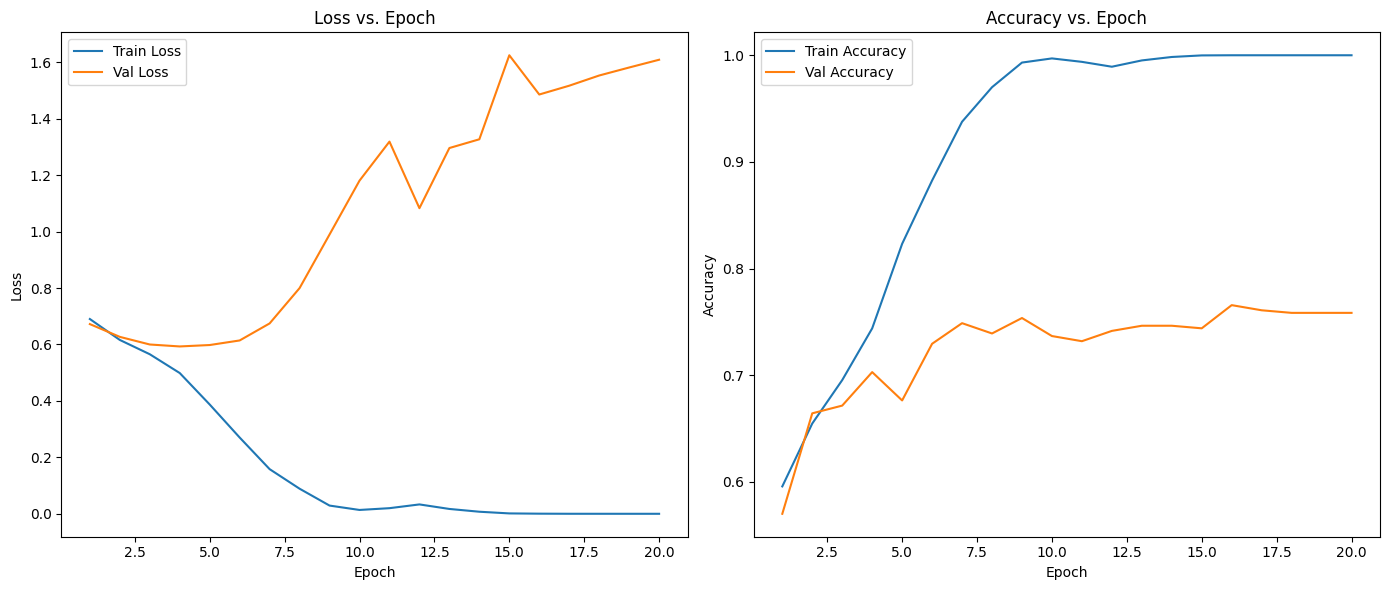

Confusion Matrix:
[[201  41]
 [ 50 121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       242
           1       0.75      0.71      0.73       171

    accuracy                           0.78       413
   macro avg       0.77      0.77      0.77       413
weighted avg       0.78      0.78      0.78       413

Precision: 0.7739, Recall: 0.7691, F1 or DSC Score: 0.7711, AUC: 0.7691


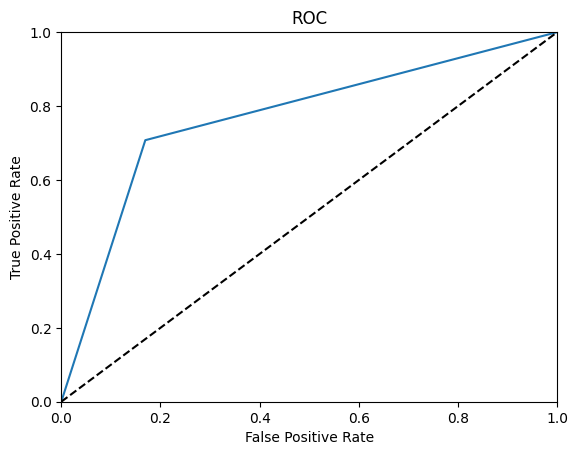

In [ ]:
visualize_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_model(model, test_loader)

# Q2

## initialize

### Import libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, save_img
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import VGG16
from keras.applications import ResNet50
from keras import models
from keras import layers
from keras import optimizers
from keras.optimizers.schedules import ExponentialDecay

### connect to google drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2-2) Pre-Processing

### load data

#### for data augmatation

In [3]:
test_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/HW2_Dataset/Test'
train_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/HW2_Dataset/Train'
augmented_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), class_mode='binary')
train_images, train_labels = next(train_generator)

Found 702 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(224, 224),batch_size=10,class_mode='binary')
test_images, test_labels = next(test_generator)

Found 100 images belonging to 2 classes.


In [5]:
augmented_dir_cats = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug/Cats'
augmented_dir_dogs = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug/Dogs'
augmented_train_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug'

#### for models

In [5]:
test_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/HW2_Dataset/Test'
train_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/HW2_Dataset/Train'
augmented_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug'
augmented_dir_cats = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug/Cats'
augmented_dir_dogs = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug/Dogs'
augmented_train_dir = '/content/drive/MyDrive/Deep_learning/HW2/Q2 Dataset/final_aug'
batch_size = 10

In [6]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), class_mode='categorical', batch_size=128, subset='training')
validation_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), class_mode='categorical', batch_size=128, subset='validation')
test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224), class_mode='categorical', batch_size=128)
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 492 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### data check

In [11]:
train_samples = list(train_generator.class_indices.keys())
print(train_samples)

test_samples = list(test_generator.class_indices.keys())
print(test_samples)

['Cats', 'Dogs']
['Cats', 'Dogs']


In [13]:
def display_samples(images, labels, class_labels):
    for i, label in enumerate(class_labels):
        index = np.where(labels == i)[0][0]

        plt.imshow(images[index])
        plt.title(label)
        plt.show()




train set:


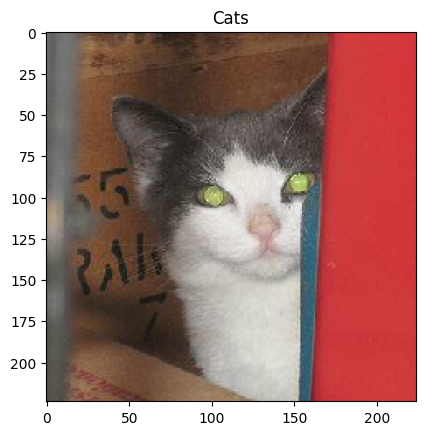

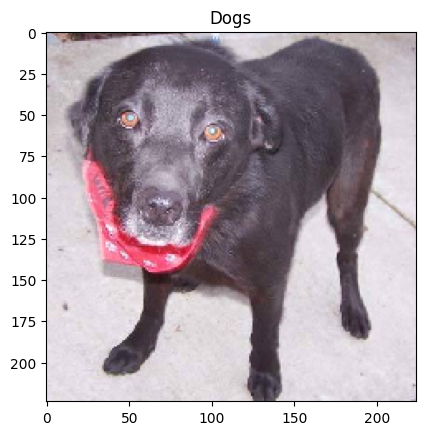




test set:


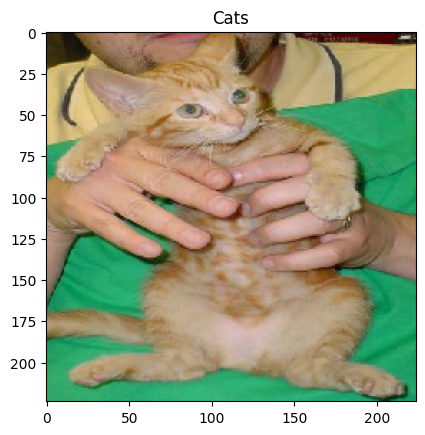

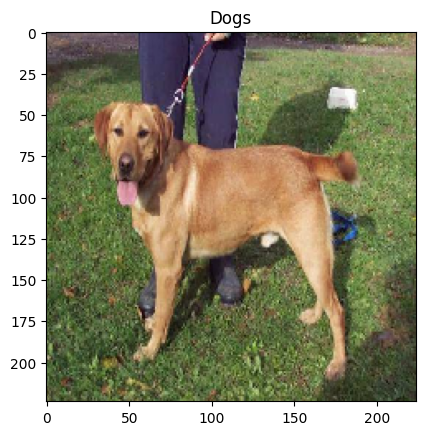

In [14]:
print("\n\n\ntrain set:")
display_samples(train_images, train_labels, train_samples)
print("\n\n\ntest set:")
display_samples(test_images, test_labels, test_samples)

In [6]:
def count_samples(generator, class_labels):
    counts = {label: 0 for label in class_labels}

    for label in generator.labels:
        class_label = class_labels[label]
        counts[class_label] += 1

    return counts

In [12]:
train_counts = count_samples(train_generator, train_samples)
print(f'Train counts: {train_counts}')

test_counts = count_samples(test_generator, test_samples)
print(f'Test counts: {test_counts}')

Train counts: {'Cats': 350, 'Dogs': 352}
Test counts: {'Cats': 50, 'Dogs': 50}


### data augmentation

In [16]:
andis = 0
for batch_index in range(len(train_generator)):
    images, labels = train_generator[batch_index]
    andis += 1
    for i in range(len(images)):
        print(f"image number: {i+andis}")
        image = images[i]
        label = labels[i]

        image = np.expand_dims(image, axis=0)

        for epoch in range(50):
            augmentation = random.choice(['flip', 'rotate', 'zoom'])

            if augmentation == 'flip':
                datagen = ImageDataGenerator(horizontal_flip=True)
            elif augmentation == 'rotate':
                datagen = ImageDataGenerator(rotation_range=30)
            else:
                datagen = ImageDataGenerator(zoom_range=[0.75, 1.25])

            image_augmented = datagen.random_transform(img_to_array(image[0]))

            img = array_to_img(image_augmented)

            img.save(os.path.join(augmented_dir_cats if label == 0 else augmented_dir_dogs, f'aug_{batch_index}_{i}_epoch_{epoch}.jpeg'))

image number: 1
image number: 2
image number: 3
image number: 4
image number: 5
image number: 6
image number: 7
image number: 8
image number: 9
image number: 10
image number: 11
image number: 12
image number: 13
image number: 14
image number: 15
image number: 16
image number: 17
image number: 18
image number: 19
image number: 20
image number: 21
image number: 22
image number: 23
image number: 24
image number: 25
image number: 26
image number: 27
image number: 28
image number: 29
image number: 30
image number: 31
image number: 32
image number: 2
image number: 3
image number: 4
image number: 5
image number: 6
image number: 7
image number: 8
image number: 9
image number: 10
image number: 11
image number: 12
image number: 13
image number: 14
image number: 15
image number: 16
image number: 17
image number: 18
image number: 19
image number: 20
image number: 21
image number: 22
image number: 23
image number: 24
image number: 25
image number: 26
image number: 27
image number: 28
image number: 

In [7]:
augmented_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
augmented_train_generator = augmented_datagen.flow_from_directory(augmented_dir, target_size=(224, 224), class_mode='categorical', batch_size=128, subset='training')
augmented_validation_generator = augmented_datagen.flow_from_directory(augmented_dir, target_size=(224, 224), class_mode='categorical', batch_size=128, subset='validation')

Found 24570 images belonging to 2 classes.
Found 10530 images belonging to 2 classes.


### VGG16

In [21]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.1, decay_steps=100000, decay_rate=0.002)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [23]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 18s 18s/step - loss: 0.7134 - accuracy: 0.5700
Test accuracy: 0.5699999928474426, Test loss: 0.7133709192276001


In [24]:
for layer in base_model.layers:
    layer.trainable = False

lr_schedule = ExponentialDecay(initial_learning_rate=0.1, decay_steps=100000, decay_rate=0.002)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/20
4/4 [==============================] - 56s 12s/step - loss: 6.3665 - accuracy: 0.5102 - val_loss: 1.0102 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.7825 - accuracy: 0.5285 - val_loss: 0.6720 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.6152 - accuracy: 0.6951 - val_loss: 0.5740 - val_accuracy: 0.7571
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.5555 - accuracy: 0.7175 - val_loss: 0.6383 - val_accuracy: 0.5476
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.5518 - accuracy: 0.6829 - val_loss: 1.7342 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 1.0773 - accuracy: 0.5813 - val_loss: 0.4594 - val_accuracy: 0.8048
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 0.5219 - accuracy: 0.6951 - val_loss: 0.5497 - val_accuracy: 0.8381
Epoch 8/20
4/4 [=======================

In [26]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 1s 929ms/step - loss: 0.3079 - accuracy: 0.9000
Test accuracy: 0.8999999761581421, Test loss: 0.30790525674819946


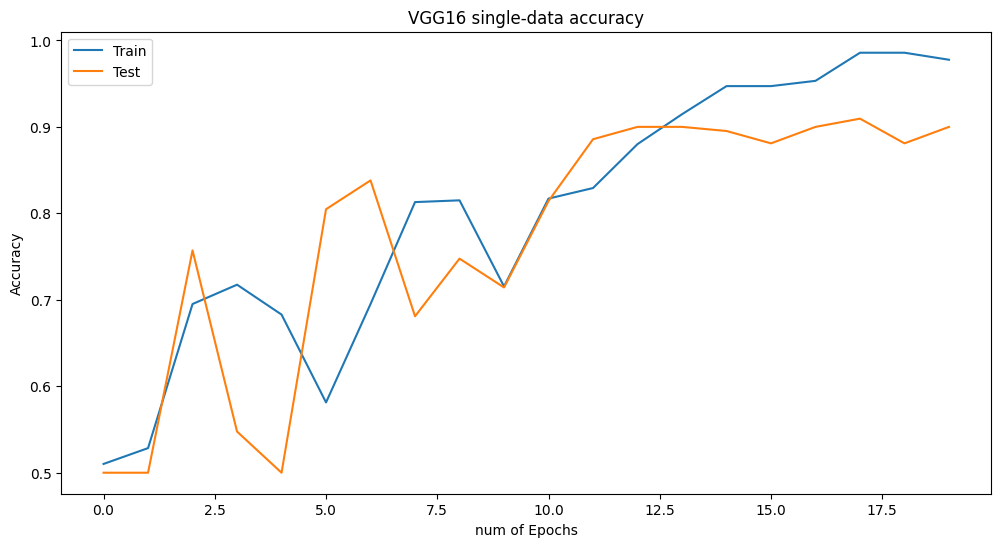

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 single-data accuracy')
plt.ylabel('Accuracy')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

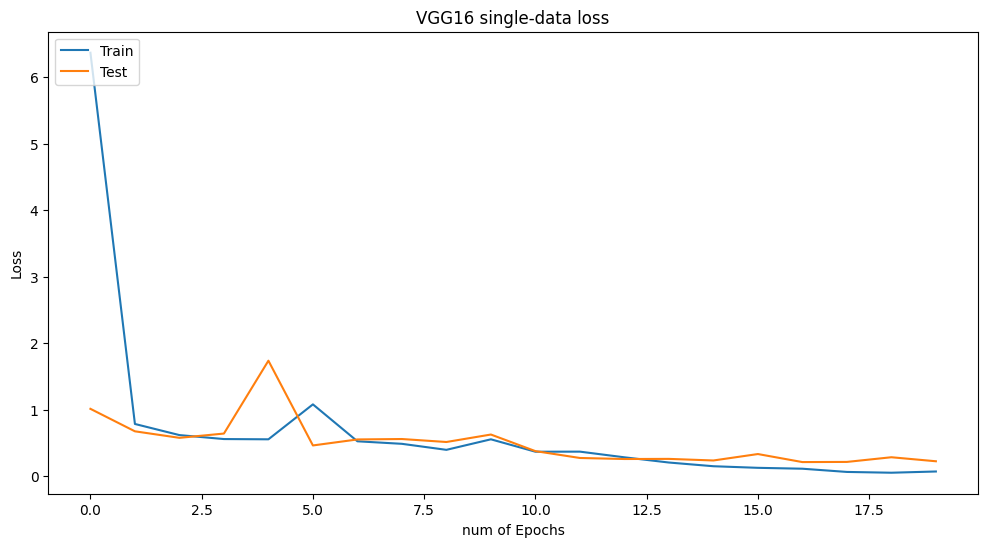

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 single-data loss')
plt.ylabel('Loss')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
4/4 [==============================] - 10s 2s/step - loss: 1.6810 - accuracy: 0.8435 - val_loss: 6.8787 - val_accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 2.1232 - accuracy: 0.4939 - val_loss: 0.7411 - val_accuracy: 0.5000
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.7349 - accuracy: 0.4939 - val_loss: 0.6902 - val_accuracy: 0.5429
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.7226 - accuracy: 0.5020 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.6974 - accuracy: 0.5020 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 6/30
4/4 [==============================] - 5s 1s/step - loss: 0.6980 - accuracy: 0.5020 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.6977 - accuracy: 0.5020 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 8/30
4/4 [========================

In [30]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 1s 946ms/step - loss: 0.6932 - accuracy: 0.5000
Test accuracy: 0.5, Test loss: 0.6931595802307129


#### train for augmented dataset

In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [33]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.002)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [34]:
for layer in base_model.layers:
    layer.trainable = False

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.002)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=20,
    validation_data=augmented_validation_generator,
    validation_steps=len(augmented_validation_generator))

Epoch 1/20
192/192 [==============================] - 213s 1s/step - loss: 0.4901 - accuracy: 0.8557 - val_loss: 0.3802 - val_accuracy: 0.8618
Epoch 2/20
192/192 [==============================] - 216s 1s/step - loss: 0.1612 - accuracy: 0.9360 - val_loss: 0.2809 - val_accuracy: 0.9080
Epoch 3/20
192/192 [==============================] - 184s 958ms/step - loss: 0.4139 - accuracy: 0.8783 - val_loss: 0.2304 - val_accuracy: 0.8972
Epoch 4/20
192/192 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8839

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 2s 2s/step - loss: 0.6139 - accuracy: 0.8700
Test accuracy: 0.8700000047683716, Test loss: 0.6138901710510254


In [ ]:
model.save('aug_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


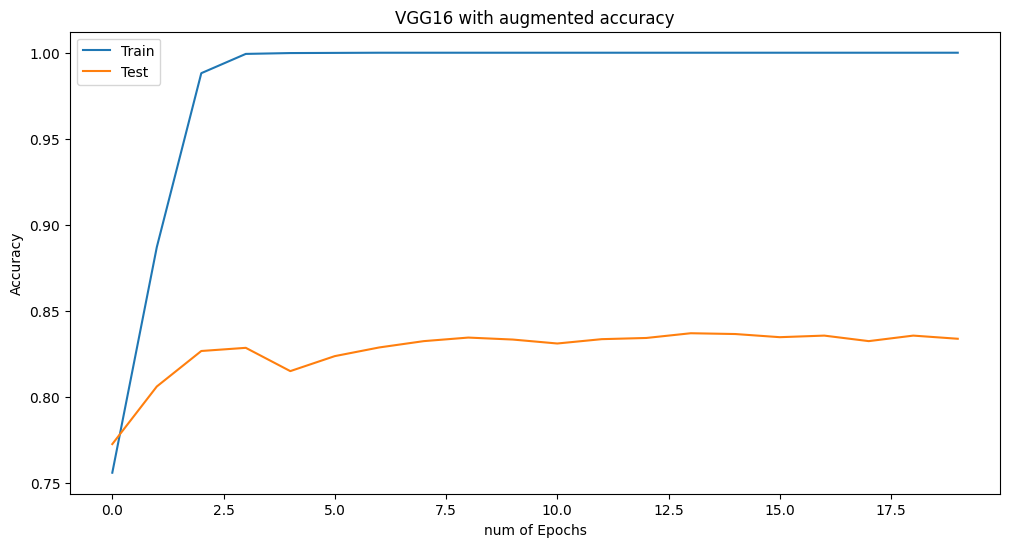

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 with augmented accuracy')
plt.ylabel('Accuracy')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 with augmented loss')
plt.ylabel('Loss')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### ResNet50

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [9]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.1, decay_steps=100000, decay_rate=0.002)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 13s 13s/step - loss: 0.7243 - accuracy: 0.4300
Test accuracy: 0.4300000071525574, Test loss: 0.724293053150177


In [11]:
for layer in base_model.layers:
    layer.trainable = False

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.002)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/20
4/4 [==============================] - 31s 5s/step - loss: 110.6402 - accuracy: 0.5041 - val_loss: 0.6896 - val_accuracy: 0.5381
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.6882 - accuracy: 0.5528 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.8244 - accuracy: 0.5061 - val_loss: 0.7369 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.7139 - accuracy: 0.4980 - val_loss: 0.7011 - val_accuracy: 0.5048
Epoch 5/20
4/4 [==============================] - 6s 2s/step - loss: 0.7440 - accuracy: 0.5203 - val_loss: 0.7261 - val_accuracy: 0.5048
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.7264 - accuracy: 0.4919 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 6s 2s/step - loss: 0.7128 - accuracy: 0.5467 - val_loss: 0.7564 - val_accuracy: 0.5000
Epoch 8/20
4/4 [======================

In [13]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 1s 854ms/step - loss: 0.6955 - accuracy: 0.5000
Test accuracy: 0.5, Test loss: 0.6955238580703735


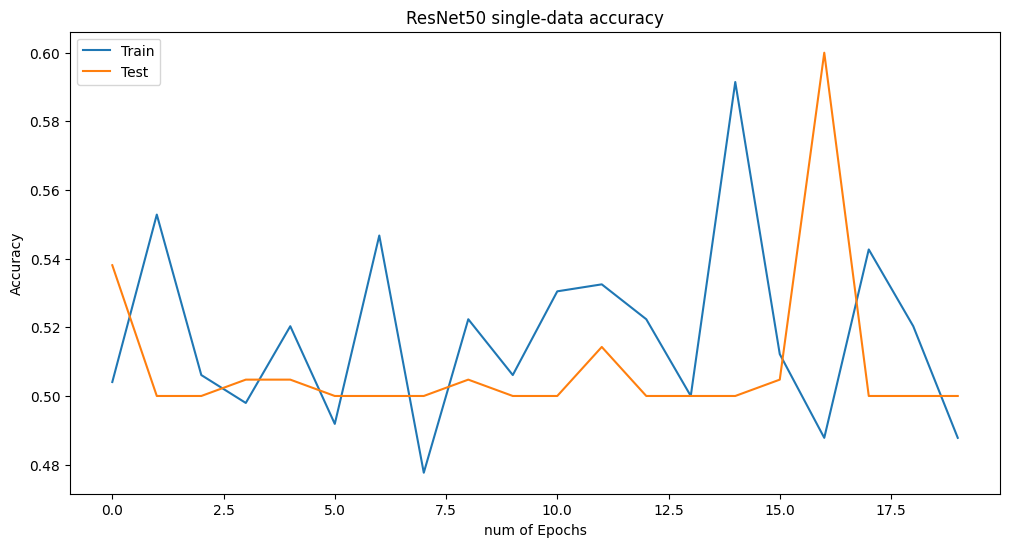

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 single-data accuracy')
plt.ylabel('Accuracy')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

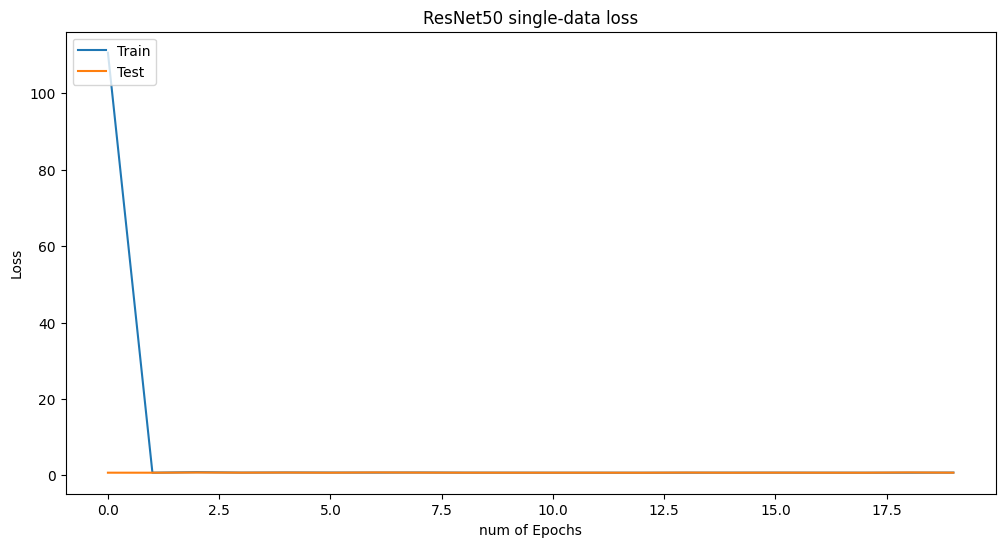

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 single-data loss')
plt.ylabel('Loss')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
4/4 [==============================] - 10s 2s/step - loss: 1.2904 - accuracy: 0.4736 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 6s 2s/step - loss: 0.6904 - accuracy: 0.5427 - val_loss: 0.7043 - val_accuracy: 0.5000
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.9748 - accuracy: 0.4776 - val_loss: 0.6954 - val_accuracy: 0.5048
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.6906 - accuracy: 0.5915 - val_loss: 0.7024 - val_accuracy: 0.5048
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.6693 - accuracy: 0.5407 - val_loss: 0.7125 - val_accuracy: 0.5048
Epoch 6/30
4/4 [==============================] - 5s 1s/step - loss: 0.8318 - accuracy: 0.5041 - val_loss: 0.6929 - val_accuracy: 0.5095
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.6862 - accuracy: 0.5163 - val_loss: 0.6905 - val_accuracy: 0.5143
Epoch 8/30
4/4 [========================

In [17]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

1/1 [==============================] - 1s 898ms/step - loss: 0.6887 - accuracy: 0.5600
Test accuracy: 0.5600000023841858, Test loss: 0.6886633038520813


#### train for augmented dataset

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [19]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.002)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [20]:
for layer in base_model.layers:
    layer.trainable = False

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.002)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])

In [21]:
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=20,
    validation_data=augmented_validation_generator,
    validation_steps=len(augmented_validation_generator))

Epoch 1/20
192/192 [==============================] - 224s 1s/step - loss: 1.4552 - accuracy: 0.5276 - val_loss: 0.6995 - val_accuracy: 0.4994
Epoch 2/20
192/192 [==============================] - 184s 960ms/step - loss: 0.6933 - accuracy: 0.5289 - val_loss: 0.6787 - val_accuracy: 0.5109
Epoch 3/20
192/192 [==============================] - 212s 1s/step - loss: 0.6910 - accuracy: 0.5107 - val_loss: 0.6848 - val_accuracy: 0.5014
Epoch 4/20
192/192 [==============================] - 212s 1s/step - loss: 0.6922 - accuracy: 0.5069 - val_loss: 0.6928 - val_accuracy: 0.5013
Epoch 5/20
192/192 [==============================] - 212s 1s/step - loss: 0.6905 - accuracy: 0.5143 - val_loss: 0.6936 - val_accuracy: 0.4986
Epoch 6/20
192/192 [==============================] - 212s 1s/step - loss: 0.6906 - accuracy: 0.5048 - val_loss: 0.6786 - val_accuracy: 0.6491
Epoch 7/20
192/192 [==============================] - 191s 991ms/step - loss: 0.6853 - accuracy: 0.5320 - val_loss: 0.6763 - val_accuracy: 

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 with augmented accuracy')
plt.ylabel('Accuracy')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 with augmented loss')
plt.ylabel('Loss')
plt.xlabel('num of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()